# Sales Analysis

## Initial Data Processing

In [1]:
#importing relevant libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

In [2]:
#setting a style for the plots
plt.style.use('fivethirtyeight')

In [3]:
#merging the monthly sales data csv files and creating a csv with the combined data

files = [file for file in os.listdir('./salesData')]

yearSales_df = pd.DataFrame()

for file in files:
    df = pd.read_csv('./salesData/'+file)
    yearSales_df = pd.concat([yearSales_df, df])
 
 
yearSales_df.to_csv('yearSales.csv', index=False)

In [4]:
#reading the combined csv into a pandas dataframe
sales_df = pd.read_csv('yearSales.csv')
sales_df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,295665,Macbook Pro Laptop,1,1700,12/30/19 00:01,"136 Church St, New York City, NY 10001"
1,295666,LG Washing Machine,1,600.0,12/29/19 07:03,"562 2nd St, New York City, NY 10001"
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001"
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016"
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301"


In [5]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


In [6]:
sales_df.isna().sum()

Order ID            545
Product             545
Quantity Ordered    545
Price Each          545
Order Date          545
Purchase Address    545
dtype: int64

## Data Cleaning

The first thing to address is null values within the data.

In [7]:
null_df = sales_df[sales_df.isna().any(axis=1)]
null_df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
264,NaN,NaN,NaN,NaN,NaN,NaN
648,NaN,NaN,NaN,NaN,NaN,NaN
680,NaN,NaN,NaN,NaN,NaN,NaN
1385,NaN,NaN,NaN,NaN,NaN,NaN
1495,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#dropping the null values as they seem to be empty rows of data
sales_df = sales_df.dropna(how='all')
sales_df.isna().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

In [9]:
#locating duplicated header rows (containing column names) repeated within the actual data
temp_df = sales_df[sales_df['Order ID'].str[:2] == 'Or']
temp_df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
254,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
705,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1101,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
2875,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
3708,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


In [10]:
#dropping the duplicated header rows and checking the data
sales_df = sales_df[sales_df['Order ID'].str[:2] != 'Or']
sales_df[sales_df['Order ID'].str[:2] == 'Or']

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


Next the data types need to be addressed. Currently all of the data are saved as object type, so data types need to be converted where necessary.

In [11]:
#converting relevant columns to numeric data
sales_df['Quantity Ordered'] = pd.to_numeric(sales_df['Quantity Ordered'])
sales_df['Price Each'] = pd.to_numeric(sales_df['Price Each'])

sales_df.dtypes

Order ID             object
Product              object
Quantity Ordered      int64
Price Each          float64
Order Date           object
Purchase Address     object
dtype: object

In [12]:
#converting order date column to datetime type
sales_df['Order Date'] = pd.to_datetime(sales_df['Order Date'], format='mixed')

sales_df.dtypes

Order ID                    object
Product                     object
Quantity Ordered             int64
Price Each                 float64
Order Date          datetime64[ns]
Purchase Address            object
dtype: object

### Creating New Columns For Analysis

In [13]:
#adding a separate month column (separated from order date) 
sales_df['Month'] = sales_df['Order Date'].dt.month
sales_df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month
0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",12
1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",12
2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",12
3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",12
4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",12


In [14]:
#creating column for total sale price (quantityOrdered * priceEach)
sales_df['Total Price'] = sales_df['Quantity Ordered'] * sales_df['Price Each']
sales_df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Total Price
0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",12,1700.00
1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",12,600.00
2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",12,11.95
3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",12,149.99
4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",12,11.95


In [15]:
#splitting purchase address string into separate components
sales_df[['Address', 'City', 'StateZip']] = sales_df['Purchase Address'].str.split(',', expand=True, n=0)
sales_df[['State', 'Zip Code']] = sales_df['StateZip'].str.split(expand=True, n=0)
sales_df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Total Price,Address,City,StateZip,State,Zip Code
0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",12,1700.00,136 Church St,New York City,NY 10001,NY,10001
1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",12,600.00,562 2nd St,New York City,NY 10001,NY,10001
2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",12,11.95,277 Main St,New York City,NY 10001,NY,10001
3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",12,149.99,410 6th St,San Francisco,CA 94016,CA,94016
4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",12,11.95,43 Hill St,Atlanta,GA 30301,GA,30301


In [16]:
#concatenating state onto city column for clarity
sales_df['City'] = sales_df.agg(lambda x: f"{x['City']} ({x['State']})", axis=1)
sales_df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Total Price,Address,City,StateZip,State,Zip Code
0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",12,1700.00,136 Church St,New York City (NY),NY 10001,NY,10001
1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",12,600.00,562 2nd St,New York City (NY),NY 10001,NY,10001
2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",12,11.95,277 Main St,New York City (NY),NY 10001,NY,10001
3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",12,149.99,410 6th St,San Francisco (CA),CA 94016,CA,94016
4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",12,11.95,43 Hill St,Atlanta (GA),GA 30301,GA,30301


In [17]:
#dropping statezip and purchase address columns
sales_df.drop(['StateZip', 'Purchase Address'], axis=1, inplace=True)
sales_df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Month,Total Price,Address,City,State,Zip Code
0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,12,1700.00,136 Church St,New York City (NY),NY,10001
1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,12,600.00,562 2nd St,New York City (NY),NY,10001
2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,12,11.95,277 Main St,New York City (NY),NY,10001
3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,12,149.99,410 6th St,San Francisco (CA),CA,94016
4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,12,11.95,43 Hill St,Atlanta (GA),GA,30301


In [18]:
#reorganizing columns
sales_df = sales_df[['Order ID', 'Product', 'Quantity Ordered', 'Price Each', 'Total Price', 
                    'Order Date', 'Month', 'Address', 'City', 'State', 'Zip Code']]
sales_df.head()

,Order ID,Product,Quantity Ordered,Price Each,Total Price,Order Date,Month,Address,City,State,Zip Code
0,295665,Macbook Pro Laptop,1,1700.00,1700.00,2019-12-30 00:01:00,12,136 Church St,New York City (NY),NY,10001
1,295666,LG Washing Machine,1,600.00,600.00,2019-12-29 07:03:00,12,562 2nd St,New York City (NY),NY,10001
2,295667,USB-C Charging Cable,1,11.95,11.95,2019-12-12 18:21:00,12,277 Main St,New York City (NY),NY,10001
3,295668,27in FHD Monitor,1,149.99,149.99,2019-12-22 15:13:00,12,410 6th St,San Francisco (CA),CA,94016
4,295669,USB-C Charging Cable,1,11.95,11.95,2019-12-18 12:38:00,12,43 Hill St,Atlanta (GA),GA,30301


## Analysis of Sales

#### What was the averge sale price and average number of items per sale?

Right now the data is separated both by order id and product purchased, which means that both the total sale price and number of items per sale could be broken up into multiple rows. In order to find average sale price and items per sale, it would help if the data for each order id was combined into a single row.

In [19]:
sales_by_id = sales_df.copy()
sales_by_id['Items'] = sales_by_id.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))
sales_by_id['Sale Amount'] = sales_by_id.groupby('Order ID')['Total Price'].transform(lambda x: sum(x))
sales_by_id['# of Items'] = sales_by_id.groupby('Order ID')['Quantity Ordered'].transform(lambda x: sum(x))

#Now with these new columns, the quantity ordered/price each/total price columns are no longer relevant here because 
#those were based on single items totals before data was combined by order id, so those columns should be dropped
sales_by_id.drop(['Quantity Ordered', 'Price Each', 'Total Price'], axis=1)

,Order ID,Product,Order Date,Month,Address,City,State,Zip Code,Items,Sale Amount,# of Items
0,295665,Macbook Pro Laptop,2019-12-30 00:01:00,12,136 Church St,New York City (NY),NY,10001,Macbook Pro Laptop,1700.00,1
1,295666,LG Washing Machine,2019-12-29 07:03:00,12,562 2nd St,New York City (NY),NY,10001,LG Washing Machine,600.00,1
2,295667,USB-C Charging Cable,2019-12-12 18:21:00,12,277 Main St,New York City (NY),NY,10001,USB-C Charging Cable,11.95,1
3,295668,27in FHD Monitor,2019-12-22 15:13:00,12,410 6th St,San Francisco (CA),CA,94016,27in FHD Monitor,149.99,1
4,295669,USB-C Charging Cable,2019-12-18 12:38:00,12,43 Hill St,Atlanta (GA),GA,30301,USB-C Charging Cable,11.95,1
...,...,...,...,...,...,...,...,...,...,...,...
186845,222905,AAA Batteries (4-pack),2019-06-07 19:02:00,6,795 Pine St,Boston (MA),MA,02215,AAA Batteries (4-pack),2.99,1
186846,222906,27in FHD Monitor,2019-06-01 19:29:00,6,495 North St,New York City (NY),NY,10001,27in FHD Monitor,149.99,1
186847,222907,USB-C Charging Cable,2019-06-22 18:57:00,6,319 Ridge St,San Francisco (CA),CA,94016,USB-C Charging Cable,11.95,1
186848,222908,USB-C Charging Cable,2019-06-26 18:35:00,6,916 Main St,San Francisco (CA),CA,94016,USB-C Charging Cable,11.95,1


In [20]:
#Dropping duplicate rows (so the same order does not appear multiple times and skew the results)
sales_by_id = sales_by_id.drop_duplicates()

In [21]:
sales_by_id[['Sale Amount', '# of Items']].describe()

,Sale Amount,# of Items
count,185686.000000,185686.000000
mean,206.841353,1.214847
std,348.852895,0.549790
min,2.990000,1.000000
25%,11.950000,1.000000
50%,18.790000,1.000000
75%,300.000000,1.000000
max,3779.990000,9.000000


The average sale amount is $206.84, and the vast majority of sales consist of only a single item. Knowing that the majority of customers are only purchasing one item per sale presents an important sales opportunity for this business. Cross-selling, product bundling, and discounts for certain price or quantity thresholds could all be helpful in increasing the number of items sold per order and thereby increase sale amounts.

#### What products are most often sold together?

In [22]:
#creating a dataframe for only orders that contained more than one product type
multi_item_sales = sales_df[sales_df['Order ID'].duplicated(keep=False)].copy()
multi_item_sales.head()

,Order ID,Product,Quantity Ordered,Price Each,Total Price,Order Date,Month,Address,City,State,Zip Code
16,295681,Google Phone,1,600.00,600.00,2019-12-25 12:37:00,12,79 Elm St,Boston (MA),MA,02215
17,295681,USB-C Charging Cable,1,11.95,11.95,2019-12-25 12:37:00,12,79 Elm St,Boston (MA),MA,02215
18,295681,Bose SoundSport Headphones,1,99.99,99.99,2019-12-25 12:37:00,12,79 Elm St,Boston (MA),MA,02215
19,295681,Wired Headphones,1,11.99,11.99,2019-12-25 12:37:00,12,79 Elm St,Boston (MA),MA,02215
36,295698,Vareebadd Phone,1,400.00,400.00,2019-12-13 14:32:00,12,175 1st St,New York City (NY),NY,10001


In [23]:
#combining products for the same sale into a single row, deleting suplicate rows and unnecessary data
multi_item_sales['Items'] = multi_item_sales.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))
multi_item_sales = multi_item_sales[['Order ID', 'Items']].drop_duplicates()
multi_item_sales.head()

,Order ID,Items
16,295681,"Google Phone,USB-C Charging Cable,Bose SoundSp..."
36,295698,"Vareebadd Phone,USB-C Charging Cable"
42,295703,"AA Batteries (4-pack),Bose SoundSport Headphones"
66,295726,"iPhone,Lightning Charging Cable"
76,295735,"iPhone,Apple Airpods Headphones,Wired Headphones"


In [24]:
#counting occurences for combinations of two items
count = Counter()

for row in multi_item_sales['Items']:
    item_list = row.split(',')
    count.update(Counter(combinations(item_list, 2)))
    
count.most_common(10)

[(('iPhone', 'Lightning Charging Cable'), 1005),
 (('Google Phone', 'USB-C Charging Cable'), 987),
 (('iPhone', 'Wired Headphones'), 447),
 (('Google Phone', 'Wired Headphones'), 414),
 (('Vareebadd Phone', 'USB-C Charging Cable'), 361),
 (('iPhone', 'Apple Airpods Headphones'), 360),
 (('Google Phone', 'Bose SoundSport Headphones'), 220),
 (('USB-C Charging Cable', 'Wired Headphones'), 160),
 (('Vareebadd Phone', 'Wired Headphones'), 143),
 (('Lightning Charging Cable', 'Wired Headphones'), 92)]

This information is useful for constructing deals and product bundles for encouraging customers to purchase multiple products and increase sales.

#### What were the best and worst months for sales?

In [25]:
#grouping by month and getting aggregate values
monthly_sums = sales_df.groupby('Month').sum(numeric_only=True)
monthly_sums

,Quantity Ordered,Price Each,Total Price
Month,,,
1,10903,1811768.38,1822256.73
2,13449,2188884.72,2202022.42
3,17005,2791207.83,2807100.38
4,20558,3367671.02,3390670.24
5,18667,3135125.13,3152606.75
6,15253,2562025.61,2577802.26
7,16072,2632539.56,2647775.76
8,13448,2230345.42,2244467.88
9,13109,2084992.09,2097560.13


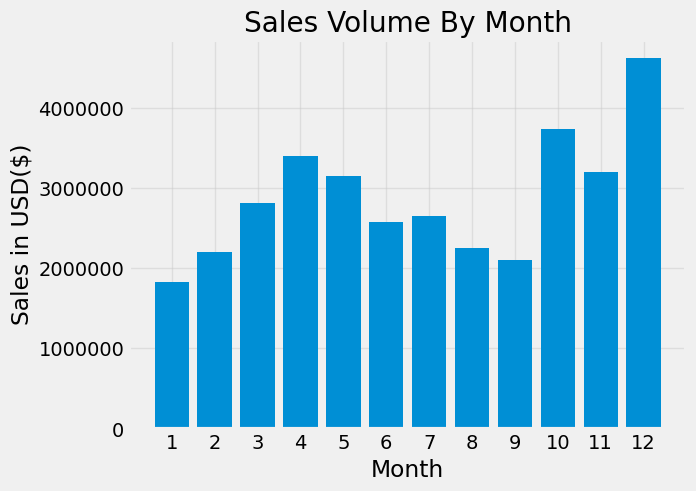

In [26]:
#plotting sales volume by month
months = range(1,13)

plt.bar(months, monthly_sums['Total Price'])
plt.grid(alpha=0.5)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(months)
plt.ylabel('Sales in USD($)')
plt.xlabel('Month')
plt.title('Sales Volume By Month')
plt.show()

December had the highest sales volume for the year with January having the lowest. This makes sense with the known seasonality of spending. Most people spend heavily for the holidays in December and are inclined to cut back during the next month. Sales and promotions could be offered during January to try and increase sales.

#### How do sales fluctuate throughout the day? 

In [27]:
#separating hour from the order date column
sales_df['Hour'] = sales_df['Order Date'].dt.hour
sales_df['Minute'] = sales_df['Order Date'].dt.minute
sales_df.head()

,Order ID,Product,Quantity Ordered,Price Each,Total Price,Order Date,Month,Address,City,State,Zip Code,Hour,Minute
0,295665,Macbook Pro Laptop,1,1700.00,1700.00,2019-12-30 00:01:00,12,136 Church St,New York City (NY),NY,10001,0,1
1,295666,LG Washing Machine,1,600.00,600.00,2019-12-29 07:03:00,12,562 2nd St,New York City (NY),NY,10001,7,3
2,295667,USB-C Charging Cable,1,11.95,11.95,2019-12-12 18:21:00,12,277 Main St,New York City (NY),NY,10001,18,21
3,295668,27in FHD Monitor,1,149.99,149.99,2019-12-22 15:13:00,12,410 6th St,San Francisco (CA),CA,94016,15,13
4,295669,USB-C Charging Cable,1,11.95,11.95,2019-12-18 12:38:00,12,43 Hill St,Atlanta (GA),GA,30301,12,38


In [28]:
#generating count of orders for each hour
hours = [hour for hour, df in sales_df.groupby('Hour')]
hours_count = sales_df.groupby(['Hour']).count()
hours_count.head()

,Order ID,Product,Quantity Ordered,Price Each,Total Price,Order Date,Month,Address,City,State,Zip Code,Minute
Hour,,,,,,,,,,,,
0,3910,3910,3910,3910,3910,3910,3910,3910,3910,3910,3910,3910
1,2350,2350,2350,2350,2350,2350,2350,2350,2350,2350,2350,2350
2,1243,1243,1243,1243,1243,1243,1243,1243,1243,1243,1243,1243
3,831,831,831,831,831,831,831,831,831,831,831,831
4,854,854,854,854,854,854,854,854,854,854,854,854


<function matplotlib.pyplot.show(close=None, block=None)>

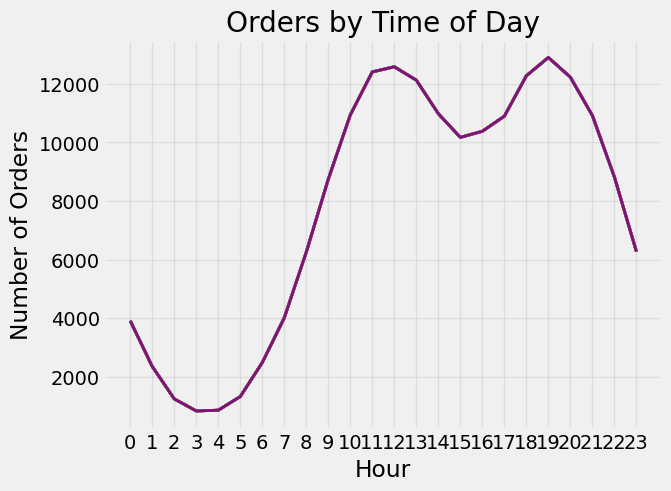

In [29]:
#plotting number of orders by time of day (hour of day)
plt.plot(hours, hours_count, linewidth=2)
plt.xticks(hours)
plt.grid(alpha=0.5)
plt.xlabel('Hour')
plt.ylabel('Number of Orders')
plt.title('Orders by Time of Day')
plt.show

Sales peaked at both 12:00 and 19:00, with the lowest number of sales occuring overnight between 01:00 and 06:00. Sales remain high during lunch hours and in the evening. Advertisements could be promoted during or directly before these peak sales windows. 

#### What locations had the highest and lowest sales?

In [30]:
city_sums = sales_df.groupby('City').sum(numeric_only=True)
city_sums.sort_values(by=['Total Price'], ascending=False)

,Quantity Ordered,Price Each,Total Price,Month,Hour,Minute
City,,,,,,
San Francisco (CA),50239,8211461.74,8262203.91,315520,643265,1319477
Los Angeles (CA),33289,5421435.23,5452570.80,208325,427444,866638
New York City (NY),27932,4635370.83,4664317.43,175741,357696,733598
Boston (MA),22528,3637409.77,3661642.01,141112,288225,590442
Atlanta (GA),16602,2779908.20,2795498.58,104794,214264,442932
Dallas (TX),16730,2752627.82,2767975.40,104620,214390,435155
Seattle (WA),16553,2733296.01,2747755.48,104941,213292,436368
Portland (OR),11303,1860558.22,1870732.34,70621,144421,295533
Austin (TX),11153,1809873.61,1819581.75,69829,141946,289060


<function matplotlib.pyplot.show(close=None, block=None)>

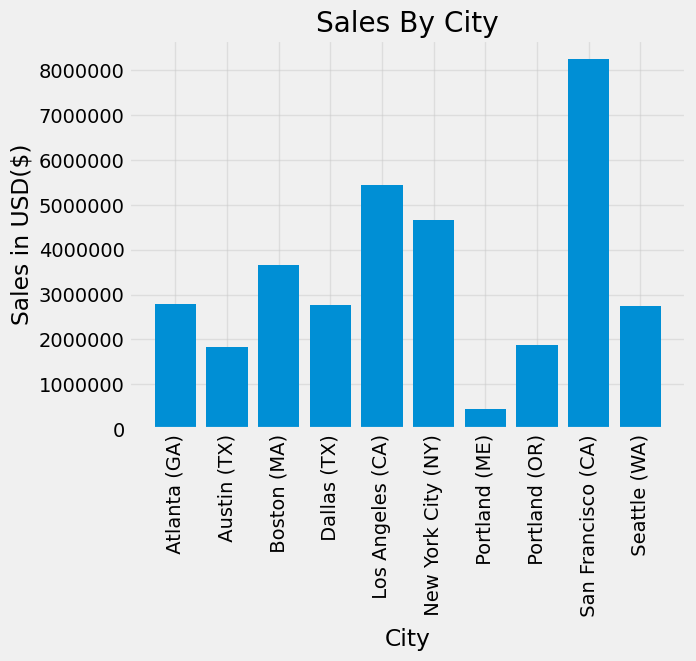

In [31]:
cities = [city for city, df in sales_df.groupby('City')]

plt.bar(cities, city_sums['Total Price'])
plt.grid(alpha=0.5)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(cities, rotation=90)
plt.ylabel('Sales in USD($)')
plt.xlabel('City')
plt.title('Sales By City')
plt.show

Portland, Maine had the lowest amount of sales by far. Portland, Oregon and Austin, Texas also had relatively low numbers. It might be beneficial to target advertisements or run local promotions in these areas to drive sales. On the other end of the spectrum, San Francisco had the highest sales of any city by far. It would be interesting to look at advertising data from this business as well as local demographic and job data to get a better understanding of what factors could be influencing sales in each location.

#### What products sell the most and least?

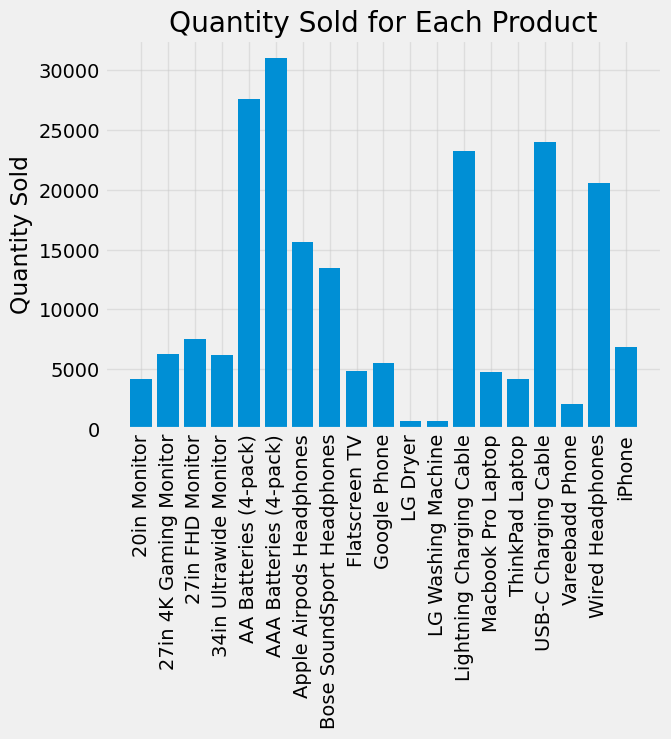

In [32]:
#grouping orders by product and getting the sum of quantity ordered
grouped_prods = sales_df.groupby('Product')
quantity_ordered = grouped_prods['Quantity Ordered'].sum()

products = [product for product, df in grouped_prods]

#plotting quantity sold per product
plt.bar(products, quantity_ordered)
plt.grid(alpha=0.5)
plt.xticks(products, rotation=90)
plt.ylabel('Quantity Sold')
plt.title('Quantity Sold for Each Product')
plt.show()

Battery packs are the most popular item in terms of quantity sold, followed by charging cables and headphones. The washing machine and dryer sold the least number of units. It would also be helpful to consider product price when looking at sales quantities, as that might influence number of sales.

In [33]:
#getting the individual price of each product
prices = grouped_prods['Price Each'].mean()
print(prices)

Product
20in Monitor                   109.99
27in 4K Gaming Monitor         389.99
27in FHD Monitor               149.99
34in Ultrawide Monitor         379.99
AA Batteries (4-pack)            3.84
AAA Batteries (4-pack)           2.99
Apple Airpods Headphones       150.00
Bose SoundSport Headphones      99.99
Flatscreen TV                  300.00
Google Phone                   600.00
LG Dryer                       600.00
LG Washing Machine             600.00
Lightning Charging Cable        14.95
Macbook Pro Laptop            1700.00
ThinkPad Laptop                999.99
USB-C Charging Cable            11.95
Vareebadd Phone                400.00
Wired Headphones                11.99
iPhone                         700.00
Name: Price Each, dtype: float64


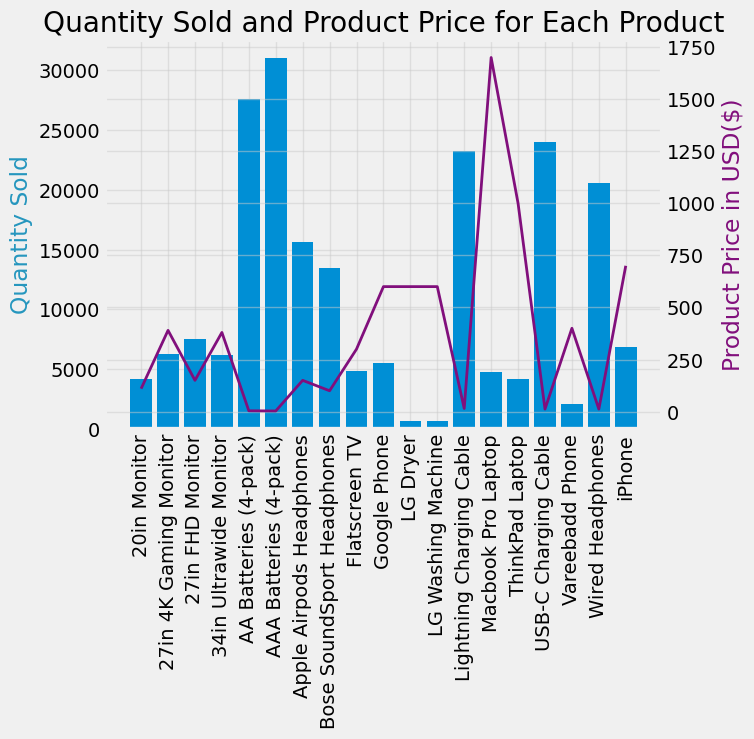

In [34]:
#plotting product price over quantity sold for each product
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(products, quantity_ordered)
ax2.plot(products, prices, '#810f7c', linewidth=2)
ax1.grid(alpha=0.5)
ax2.grid(alpha=0.5)

ax1.set_ylabel('Quantity Sold', color='#2596be')
ax2.set_ylabel('Product Price in USD($)', color='#810f7c') 
ax1.tick_params(axis='x', labelrotation = 90)
plt.title('Quantity Sold and Product Price for Each Product')

plt.show()

Clearly the products that sold most frequently are the lowest priced products. It also makes sense that batteries sold more because they need to be replaced regularly at much higher frequency than any other products in this inventory. 

#### What was the sales volume for each product over the year?

In [35]:
#getting sales volume by product
prod_sales = grouped_prods['Total Price'].sum()
prod_sales.head()

Product
20in Monitor               454148.71
27in 4K Gaming Monitor    2435097.56
27in FHD Monitor          1132424.50
34in Ultrawide Monitor    2355558.01
AA Batteries (4-pack)      106118.40
Name: Total Price, dtype: float64

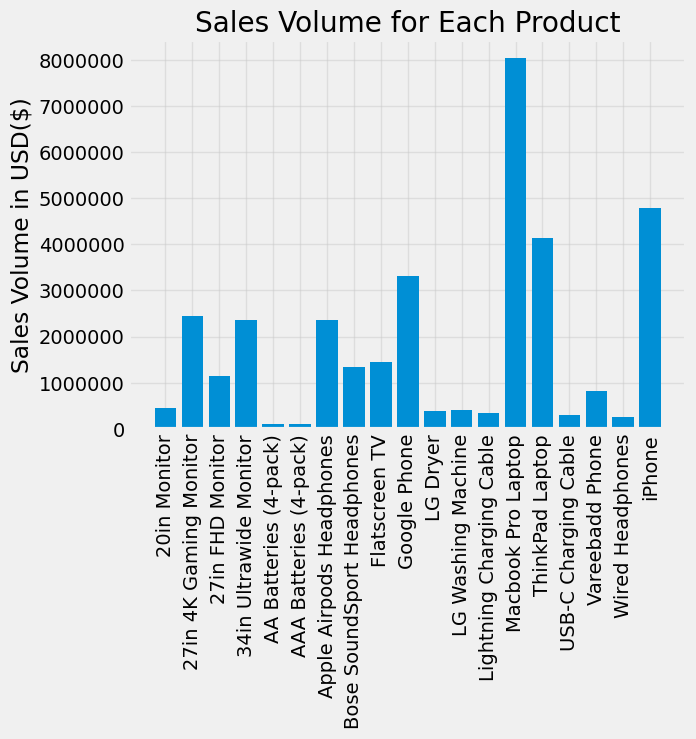

In [36]:
#plotting sales volume by product
plt.bar(products, prod_sales)
plt.grid(alpha=0.5)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(products, rotation=90)
plt.ylabel('Sales Volume in USD($)')
plt.title('Sales Volume for Each Product')
plt.show()

The Macbook Pro Laptop contributed the most sales dollars of any product by far, followed by the iPhone. Again, price data will be incorporated to gain a deeper understanding of this data.

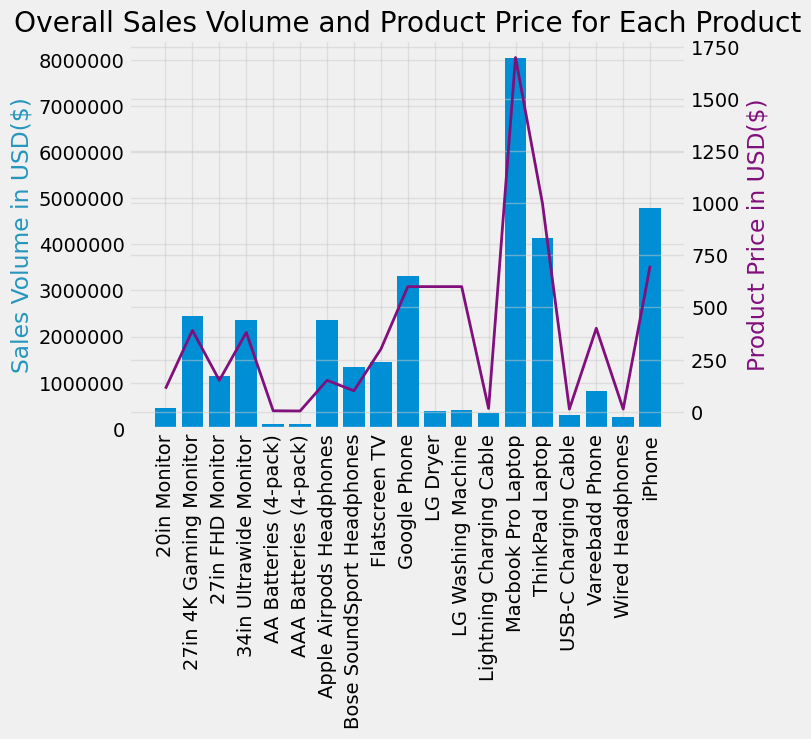

In [37]:
#plotting product price over sales volume for each product
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(products, prod_sales)
ax2.plot(products, prices, '#810f7c', linewidth=2)
ax1.grid(alpha=0.5)
ax2.grid(alpha=0.5)
ax1.ticklabel_format(style='plain', axis='y')

ax1.set_ylabel('Sales Volume in USD($)', color='#2596be')
ax2.set_ylabel('Product Price in USD($)', color='#810f7c') 
ax1.tick_params(axis='x', labelrotation = 90)
plt.title('Overall Sales Volume and Product Price for Each Product')

plt.show()

It is clear that the majority of revenue is being generated by the higher ticket items, even though they are being sold in lesser quantities. The washing machine and dryer, however, are high priced items that sell in low quantities and contribute a relatively low proportion of total revenue. 